## Combine everything

In [1]:
## Read data
import pandas as pd
import re
from collections import Counter
import nltk
from nltk.tokenize import  word_tokenize
from pandarallel import pandarallel
import pickle

import os
import numpy as np

### Actual dataframe

In [2]:
%%time
post_data_full = pd.read_csv('wallstreetbets_submissions_zstextract.csv')
post_data_full.shape

/opt/conda/lib/python3.7/site-packages/IPython/core/magics/execution.py:1335: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


CPU times: user 13.4 s, sys: 1.85 s, total: 15.3 s
Wall time: 19.5 s


(2218243, 14)

In [3]:
import datetime

post_data_full['timestamp'] = post_data_full['created_utc'].apply(datetime.datetime.fromtimestamp)
post_data_full['timestamp'].min()

Timestamp('2012-04-11 16:40:40')

In [4]:
def clean_text(text):
    # Remove all text between square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove all text between parentheses
    text = re.sub(r'\(.*?\)', '', text)
    
    # Remove all text between curly braces
    text = re.sub(r'\{.*?\}', '', text)
    
    # Remove all text between angle brackets
    text = re.sub(r'<.*?>', '', text)
    
    # Remove all text between double quotes
    #text = re.sub(r'"(.*?)"', '', text)
    
    # Remove all text between single quotes
    #text = re.sub(r"'(.*?)'", '', text)
    
    # Remove everything between **____**
    text = re.sub(r'\*\*(.*?)\*\*','',text)
    
    # Remove words followed by ^
    text = re.sub(r'(\^\w*)','',text)
    
    # Remove mentions, hashtags, links
    text = re.sub(r'\||:|\-|\n|(@\w+.*?)|(http\w\S+.*?)|(#\w+)','',text)
    
    # Remove all ^Your daily posts
    text = re.sub(r'^Your daily trading discussion.*|^We are now using AutoModerator.*|^Every time a new submission.*|^Trading discussion only.*','',text)
    
    # Remove all newlines, tabs, and extra whitespace
    text = re.sub(r'[\n\t]+', ' ', text)
    text = re.sub(r'\s{2,}', ' ', text)
    
    
    return text

In [5]:
%%time

pandarallel.initialize()
post_data_full['clean_text'] = post_data_full['body'].parallel_apply(lambda x: clean_text(str(x)))
post_data_full = post_data_full[['id','title','clean_text','author','timestamp','upvotes','num_comments','score']]
post_data_full.groupby(['clean_text'])['author'].count().sort_values(ascending=False).head(5)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 2.56 s, sys: 1 s, total: 3.56 s
Wall time: 10 s


clean_text
            1400263
nan          661710
&amp;;         1012
                648
Discuss.        509
Name: author, dtype: int64

In [30]:
## Creating a copy
df = post_data_full.copy()

### Topic LDA

In [31]:
label = pd.read_parquet('label_lda.parquet')

df['topic_label'] = label
df.columns

Index(['id', 'title', 'clean_text', 'author', 'timestamp', 'upvotes',
       'num_comments', 'score', 'topic_label'],
      dtype='object')

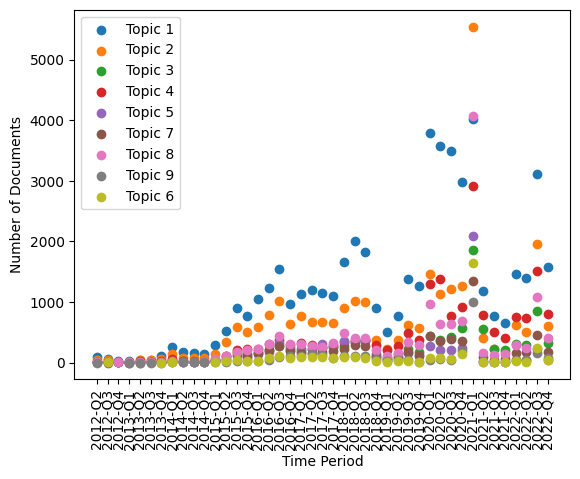

In [12]:
import matplotlib.pyplot as plt

#df['date'] = pd.to_datetime(df['date'])
df['time_period'] = pd.PeriodIndex(df['timestamp'], freq='Q')
count_df = df.groupby(['time_period', 'topic_label']).size().reset_index(name='count')

count_df['time_period'] = count_df['time_period'].dt.strftime('%Y-Q%q')

# Plot the topic timeline
fig, ax = plt.subplots()
for topic in count_df.loc[count_df['topic_label'] != 0, 'topic_label'].unique():
    topic_data = count_df[count_df['topic_label'] == topic]
    ax.scatter(topic_data['time_period'], topic_data['count'], label='Topic {}'.format(topic))
ax.set_xlabel('Time Period')
ax.set_ylabel('Number of Documents')
ax.legend()
plt.xticks(rotation=90)
#ax.set_xticks(quarter_periods)
#ax.set_xticklabels(quarter_periods.strftime('%Y-Q%q'))
plt.show()

Topic 0: Robinhood app, stock trading, and related terminology like "dd" (due diligence), "rh" (Robinhood), and "stonks".

Topic 1: Options trading, including call and put options, and various timeframes (day, week, year).

Topic 2: General discussions on stocks and the market, with terms like "bb" (Blackberry), "wall" (Wall Street), and "street".

Topic 3: Short selling, stock prices, and related terms like "squeeze" (short squeeze), "tendies" (profits), and "nio" (a Chinese electric vehicle company).

Topic 4: Hedge funds, news, and various other topics like the SEC (Securities and Exchange Commission), Donald Trump, and cryptocurrencies.

Topic 5: Buying, holding, and selling stocks, as well as various other related terms like "dip" (a temporary drop in stock prices) and "earnings".

Topic 6: Specific stocks that have gained a lot of attention on WSB, including AMC, Nokia, and Dogecoin, as well as related terms like "moon" and "rocket".

Topic 7: General discussions on stocks and related topics, as well as various other terms like "dogecoin" and "autist".

Topic 8: Discussions related to investing, including the WSB community itself, as well as related terms like "retard" (used humorously) and "gain".

Topic 9: GameStop (GME), a stock that gained a lot of attention on WSB in early 2021, as well as related terms like "next" and "buy".

In [13]:
df.columns

Index(['id', 'title', 'clean_text', 'author', 'timestamp', 'upvotes',
       'num_comments', 'score', 'topic_label', 'time_period'],
      dtype='object')

### NER Spacy - Large

In [33]:
ner_lg = pd.read_parquet('ner_lg.parquet')

df = pd.concat([df, ner_lg], axis=1)
df.columns

Index(['id', 'title', 'clean_text', 'author', 'timestamp', 'upvotes',
       'num_comments', 'score', 'topic_label', 'title_ner_lg', 'text_ner_lg'],
      dtype='object')

In [34]:
df.head()

,id,title,clean_text,author,timestamp,upvotes,num_comments,score,topic_label,title_ner_lg,text_ner_lg
0,s4jw1,Earnings season is here. Place your bets.,I know that /r/investing is a great place for ...,[deleted],2012-04-11 16:40:40,16,22,13,2,[],[Google]
1,s6r57,"GOOG - beat estimates, price barely rises.",nan,[deleted],2012-04-12 20:37:31,5,0,2,0,[],[]
2,sd5ai,My poorly timed opening position for AAPL earn...,"So I missed out on GOOG, which is probably a g...",[deleted],2012-04-16 22:29:37,14,21,12,1,[],"[OTM, BTO, BTO]"
3,se66f,Anyone betting on VVUS and their potential app...,"I'm normally a long, but I've created a second...",[deleted],2012-04-17 13:41:30,1,0,1,2,"[VVUS, Qnexa]","[Qnexa, FDA]"
4,sinsk,"After HGSI spikes 97%, will share price drop a...",nan,CheeseYogi,2012-04-19 23:21:16,5,0,4,0,[HGSI],[]


### Sentiment

In [35]:
## Sentiment from Pattern Analyzer
sent_patAna = pd.read_parquet('sentiment_title_text.parquet')

df = pd.concat([df, sent_patAna], axis=1)
df.columns

Index(['id', 'title', 'clean_text', 'author', 'timestamp', 'upvotes',
       'num_comments', 'score', 'topic_label', 'title_ner_lg', 'text_ner_lg',
       'sentiment', 'sentiment_title', 'polarity', 'subjectivity',
       'polarity_title', 'subjectivity_title'],
      dtype='object')

In [36]:
df = df.rename(columns={'sentiment': 'sentiment_text', 'polarity':'polarity_text',
                        'subjectivity':'subjectivity_text'})
df.columns

Index(['id', 'title', 'clean_text', 'author', 'timestamp', 'upvotes',
       'num_comments', 'score', 'topic_label', 'title_ner_lg', 'text_ner_lg',
       'sentiment_text', 'sentiment_title', 'polarity_text',
       'subjectivity_text', 'polarity_title', 'subjectivity_title'],
      dtype='object')

In [37]:
## Sentiment from Vader
sent_vader_text = pd.read_parquet('sentiment_vader_text.parquet')
sent_vader_title = pd.read_parquet('sentiment_vader_title.parquet')

sent_vader_text = sent_vader_text.rename(columns={'sentiment': 'sentiment_text_vader', 
                                                  'pos':'pos_text',
                                                  'neg':'neg_text',
                                                  'neu':'neu_text'})
sent_vader_title = sent_vader_title.rename(columns={'sentiment': 'sentiment_title_vader', 
                                                  'pos':'pos_title',
                                                  'neg':'neg_title',
                                                  'neu':'neu_title'})

df = pd.concat([df, sent_vader_text, sent_vader_title], axis=1)
df.columns

Index(['id', 'title', 'clean_text', 'author', 'timestamp', 'upvotes',
       'num_comments', 'score', 'topic_label', 'title_ner_lg', 'text_ner_lg',
       'sentiment_text', 'sentiment_title', 'polarity_text',
       'subjectivity_text', 'polarity_title', 'subjectivity_title', 'neg_text',
       'neu_text', 'pos_text', 'compound', 'sentiment_text_vader', 'neg_title',
       'neu_title', 'pos_title', 'compound', 'sentiment_title_vader'],
      dtype='object')

## Visualisation

In [38]:
df.tail()

,id,title,clean_text,author,timestamp,upvotes,num_comments,score,topic_label,title_ner_lg,...,neg_text,neu_text,pos_text,compound,sentiment_text_vader,neg_title,neu_title,pos_title,compound,sentiment_title_vader
2218238,1006q7e,Gay bear,,Anychefanytime,2022-12-31 23:39:35,0,1,1,0,[],...,0.0,0.0,0.0,0.0,Neutral,0.0,1.000,0.000,0.0000,Neutral
2218239,1006ur4,Please identify which one of you was sitting o...,nan,dogelonian,2022-12-31 23:46:12,0,17,21,0,[],...,0.0,1.0,0.0,0.0,Neutral,0.0,0.813,0.187,0.3182,Positive
2218240,1006xbr,Society,nan,Anychefanytime,2022-12-31 23:50:08,0,2,1,0,[Society],...,0.0,1.0,0.0,0.0,Neutral,0.0,1.000,0.000,0.0000,Neutral
2218241,1006ygl,Me at the end of 2022.,nan,the-real-ben-dover,2022-12-31 23:51:48,0,6,21,0,[],...,0.0,1.0,0.0,0.0,Neutral,0.0,1.000,0.000,0.0000,Neutral
2218242,1006yjy,The gift I want after FTX,,[deleted],2022-12-31 23:51:57,0,16,32,0,[FTX],...,0.0,0.0,0.0,0.0,Neutral,0.0,0.488,0.512,0.4939,Positive


In [40]:
from collections import Counter

flat_list = [item for sublist in df['title_ner_lg'] for item in sublist]

# count values using Counter
Counter(flat_list).most_common(15)

[('GME', 141937),
 ('AMC', 76315),
 ('WSB', 29340),
 ('Robinhood', 25420),
 ('BB', 14812),
 ('Tesla', 12111),
 ('PLTR', 11019),
 ('MOON', 8472),
 ('AMD', 7947),
 ('gme', 7511),
 ('SEC', 6223),
 ('NAKD', 5448),
 ('CNBC', 4683),
 ('TSLA', 4241),
 ('NOK', 4140)]